# Importing the BONSAI database into brightway

BONSAI is a open database generated with [open code](https://gitlab.com/bonsamurais/bonsai). It is the outcome of the [GTDR](https://vbn.aau.dk/en/projects/getting-the-data-right) project, building on years of experience generating _hybrid_ input-output models.

In [6]:
from pathlib import Path
from collections import Counter

import bw2data as bd
import bw2io as bi
import bw2analyzer as bwa

from bw2io.importers.bonsai import BonsaiImporter,IOImporter

## basic setup

In [2]:
if 'bonsai_test' not in bd.projects:
    bi.remote.install_project('ecoinvent-3.10-biosphere','bonsai_test')

bd.projects.set_current('bonsai_test')

## importing BONSAI

For this presentation we've focused on the GHG, but BONSAI contains other elementary flows, like land, mineral, or fossil fuel use. 

the importer needs a mapping between the "emissions" in BONSAI and how they're called in the biosphere database.

In [27]:
biosphere_db = bd.Database(bd.config.biosphere)

# mapping between elements in the intervention matrix and the biosphere database
co_fossil = biosphere_db.get(name='Carbon monoxide, fossil',
                                     categories=('air',))
co2_non_fossil = biosphere_db.get(name='Carbon dioxide, non-fossil',
                                     categories=('air',))
co2_fossil = biosphere_db.get(name='Carbon dioxide, fossil',
                                     categories=('air',))
ch4_fossil = biosphere_db.get(name='Methane, fossil',
                                     categories=('air',))
ch4_non_fossil = biosphere_db.get(name='Methane, non-fossil',
                                     categories=('air',))
n2o = biosphere_db.get(name='Dinitrogen monoxide',categories=('air',))


map_bonsai_b3 = {'Carbon_dioxide__fossil_Air': co2_fossil['code'],
 'Carbon_dioxide__biogenic_Air': co2_non_fossil['code'],
 'Methane__fossil_Air': ch4_fossil['code'],
 'Methane__biogenic_Air': ch4_non_fossil['code'],
 'Carbon_monoxide__fossil_Air':co2_non_fossil['code'],
 'Dinitrogen_monoxide_Air':n2o['code'],
 }

In [11]:
bonsai_data_path = Path("bonsai_files")

In [ ]:
# build on a more generic IO importer that can be used for 
# importing other IO models.
issubclass(BonsaiImporter,IOImporter)

True

In [ ]:
importer = BonsaiImporter(dirpath=bonsai_data_path,
                          db_name='bonsai', # whatever name you want to give it
                          b3mapping=map_bonsai_b3,
                          )

In [9]:
importer.write_database()

100%|██████████| 1/1 [00:00<00:00, 13934.56it/s]

10:33:10+0200 [info     ] Vacuuming database            


10:33:10+0200 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 42088/42088 [00:03<00:00, 11720.64it/s]


10:33:14+0200 [info     ] Vacuuming database            
10:33:25+0200 [info     ] Starting IO table write       
10:33:26+0200 [info     ] Adding technosphere matrix    
10:33:30+0200 [info     ] Adding biosphere matrix       
10:33:30+0200 [info     ] Finalizing serialization      


In [12]:
bd.databases

Databases dictionary with 3 object(s):
	bonsai
	bonsai biosphere
	ecoinvent-3.10-biosphere

## general overview

In [9]:
bonsai_db = bd.Database('bonsai')

In [10]:
# this is a "lighter" backend since metadata on the exchanges was not needed
bonsai_db.backend

'iotable'

In [11]:
len(bonsai_db)

42088

In [12]:
n_locations = len({act['location'] for act in bonsai_db})

In [13]:
print(f"{n_locations} different locations")

50 different locations


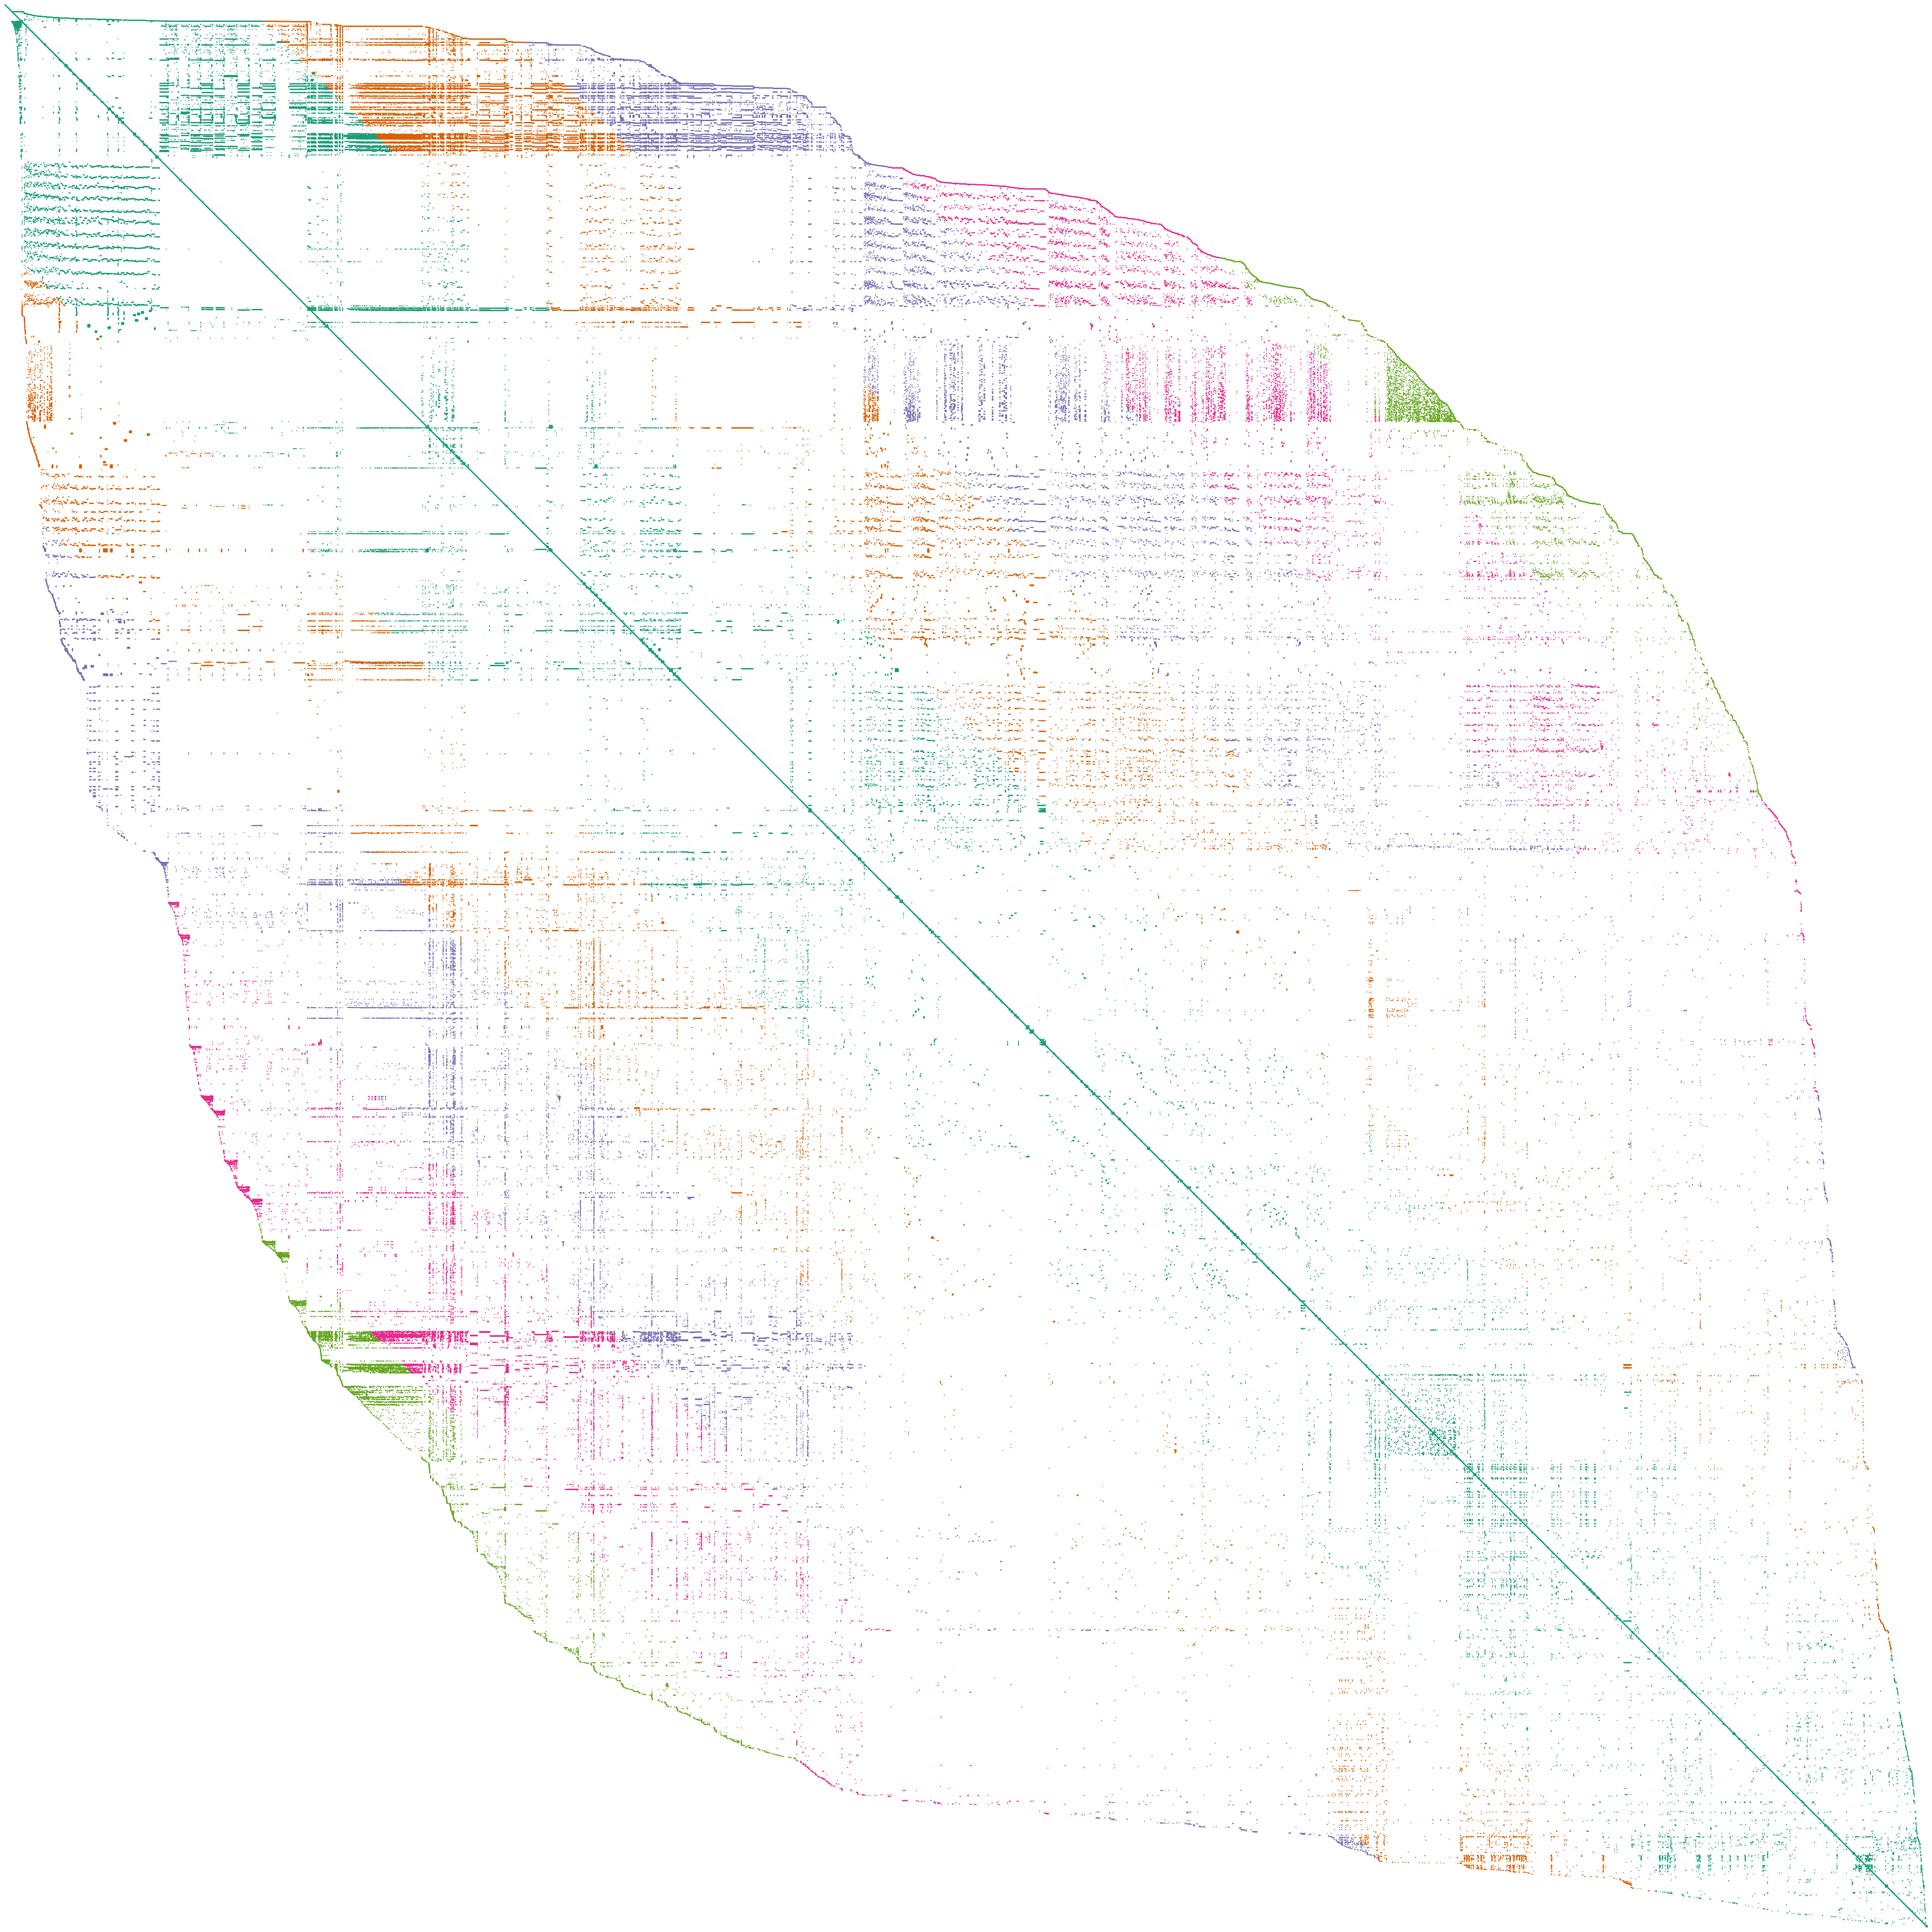

In [8]:
bonsai_db.graph_technosphere()

the database is relatively dense compared to a process-based LCA database

## calculating a carbon footprint

In [16]:
act = bonsai_db.random()
act

'market product meat, cattle' (tonnes, MT, None)

In [17]:
# some metadata available, to be improved
act.as_dict()

{'production volume': 1618.7700544822137,
 'location': 'MT',
 'code': 'M_Meat_beef|MT',
 'unit': 'tonnes',
 'reference product': 'market product meat, cattle',
 'name': 'market product meat, cattle',
 'database': 'bonsai',
 'type': 'processwithreferenceproduct',
 'id': 236406046188916747}

bear in mind units are often different from ecoinvent! the default unit of mass is tonne and of energy TJ !

In [18]:
gwp100 = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')

In [19]:
lca = act.lca(gwp100)

In [20]:
characterized_inventory = lca.to_dataframe(matrix_label='characterized_inventory')

<Axes: xlabel='kg CO2eq', ylabel='GHG'>

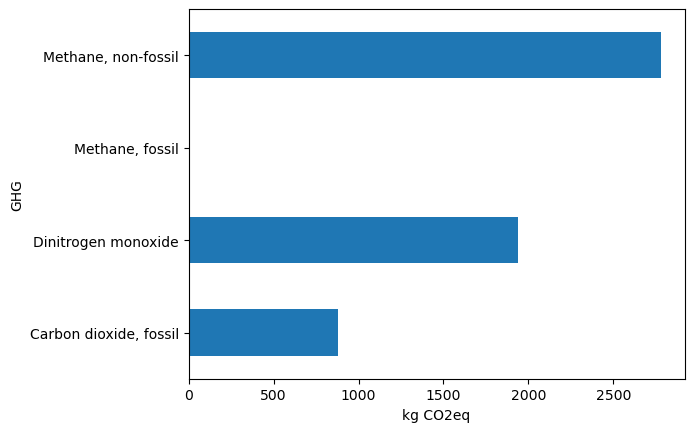

In [21]:
# e.g. contribution by elementary flow
characterized_inventory.pivot_table(index='row_name',
                                    values='amount',
                                    aggfunc='sum').amount.plot.barh(xlabel='kg CO2eq',
                                                                    ylabel='GHG',
                                                                    label='contribution by elementary flow')

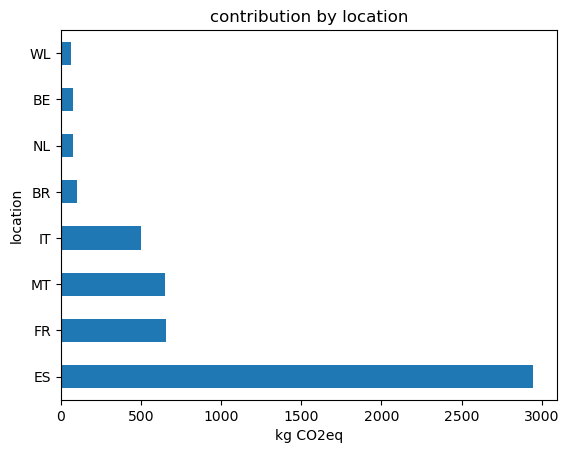

In [22]:
# contribution by location
characterized_inventory.pivot_table(index='col_location',
                                    values='amount',
                                    aggfunc='sum').sort_values(by='amount',
                                                               ascending=False).head(8).amount.plot.barh(
                                                               xlabel='kg CO2eq',ylabel='location',
                                                               title='contribution by location'
                                                               );

## io table backend

for those not familiar with this backend it is slightly different from the standard SQL backend

In [24]:
for e in act.edges():
    print(e)

Exchange: 1618.77001953125 tonnes 'market product meat, cattle' (tonnes, MT, None) to 'market product meat, cattle' (tonnes, MT, None)>
Exchange: -13.600004196166992 tonnes 'production of cattle meat' (tonnes, BE, None) to 'market product meat, cattle' (tonnes, MT, None)>
Exchange: -4.660004615783691 tonnes 'production of cattle meat' (tonnes, DE, None) to 'market product meat, cattle' (tonnes, MT, None)>
Exchange: -288.58001708984375 tonnes 'production of cattle meat' (tonnes, ES, None) to 'market product meat, cattle' (tonnes, MT, None)>
Exchange: -0.5100045204162598 tonnes 'production of cattle meat' (tonnes, GB, None) to 'market product meat, cattle' (tonnes, MT, None)>
Exchange: -2.4800045490264893 tonnes 'production of cattle meat' (tonnes, GR, None) to 'market product meat, cattle' (tonnes, MT, None)>
Exchange: -2.820004463195801 tonnes 'production of cattle meat' (tonnes, IE, None) to 'market product meat, cattle' (tonnes, MT, None)>
Exchange: -101.89000701904297 tonnes 'produc

## usage as a "LCA database"

In [176]:
# some food products
cheese_goat = bonsai_db.get(name='market product cheese, goat milk',location='FR')
cheese_cow = bonsai_db.get(name='production of cheese, whole cow milk',location='FR')
cheese_sheep = bonsai_db.get(name='market product cheese, sheep milk',location='FR')
potatoes = bonsai_db.get(name='market product potatoes',location='FR') 
bread = bonsai_db.get(name='market product bread',location='FR')
bacon = bonsai_db.get(name = 'market product bacon and ham',location='FR')

In [177]:

brightcon_dinner.delete()

/home/miguel/miniconda3/envs/ds/lib/python3.12/site-packages/bw2data/backends/base.py:760: UserWarning: 
            Please use `del databases['brightcon_dinner']` instead.
            Otherwise, the metadata and database get out of sync.
            Call `.delete(warn=False)` to skip this message in the future.
            
  warnings.warn(MESSAGE.format(self.name), UserWarning)


In [178]:
brightcon_dinner = bd.Database('brightcon_dinner')
brightcon_dinner.register()

In [179]:
raclette = brightcon_dinner.new_node(code='raclette',
                                     name='raclette',
                                     location='FR',
                                     unit='item')
raclette.save()

In [180]:
raclette.new_edge(input=cheese_sheep,amount=0.2*1e-3,type="technosphere").save()
raclette.new_edge(input=cheese_cow,amount=0.2*1e-3,type="technosphere").save()
raclette.new_edge(input=cheese_goat,amount=0.25*1e-3,type="technosphere").save()

raclette.new_edge(input=bacon,amount=0.3*1e-3,type='technosphere').save()

raclette.new_edge(input=potatoes,amount=0.2*1e-3,type="technosphere").save()
raclette.new_edge(input=bread,amount=0.2*1e-3,type="technosphere").save()

In [181]:
raclette.new_edge(input=raclette,amount=1,type='production').save()

In [182]:
bwa.print_recursive_calculation(raclette,gwp100,max_level=2)

Fraction of score | Absolute score | Amount | Activity
0001 |  8.83 |     1 | 'raclette' (item, FR, None)
  0.177 | 1.561 | 0.0002 | 'market product cheese, sheep milk' (tonnes, FR, None)
    -0.177 | -1.561 | -0.0001999 | 'production of cheese, sheep milk' (tonnes, FR, None)
  0.344 | 3.038 | 0.0002 | 'production of cheese, whole cow milk' (tonnes, FR, None)
    -0.335 | -2.96 | -0.001553 | 'market product cattle - milk' (tonnes, FR, None)
  0.265 | 2.344 | 0.00025 | 'market product cheese, goat milk' (tonnes, FR, None)
    -0.265 | -2.344 | -0.00025 | 'production of cheese, goat milk' (tonnes, FR, None)
  0.201 | 1.774 | 0.0003 | 'market product bacon and ham' (tonnes, FR, None)
    -0.0287 | -0.2536 | -3.331e-05 | 'production of pork meat' (tonnes, BE, None)
    -0.0244 | -0.2155 | -3.66e-05 | 'production of pork meat' (tonnes, DE, None)
    -0.0648 | -0.5724 | -8.81e-05 | 'production of pork meat' (tonnes, ES, None)
    -0.0635 | -0.5607 | -0.0001189 | 'production of pork meat' (to

In [183]:
df = bwa.utils.recursive_calculation_to_object(activity=raclette,
                                          lcia_method=gwp100,
                                          amount=1,
                                          as_dataframe=True,
                                          use_matrix_values=True,
                                          max_level=1)

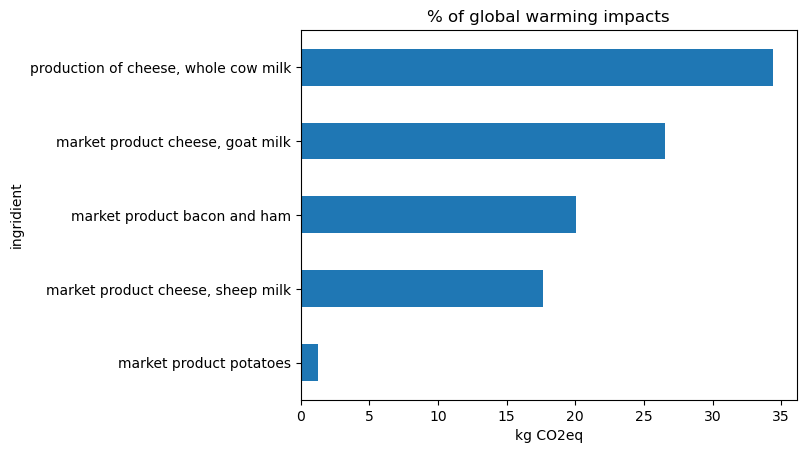

In [191]:
(df.dropna(subset='parent').set_index(
    'name').fraction.sort_values()*100).plot.barh(xlabel='kg CO2eq',
                                             ylabel='ingridient',
                                             title='% of global warming impacts');